In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, LSTM, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [2]:
# Set directories for training and testing data
train_dir = r'C:\Program Files\GoogleNet+LSTM\googlenet-lstm\dataset\Training'
test_dir = r'C:\Program Files\GoogleNet+LSTM\googlenet-lstm\dataset\Testing'

In [3]:
# Set image dimensions and batch size
img_height, img_width = 299, 299  # Default input size for InceptionV3
batch_size = 20
sequence_length = 5  # Define the sequence length for LSTM

In [4]:
# Prepare ImageDataGenerators for training and testing
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)  # No data augmentation for testing

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True  # Shuffle data for better training
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2870 images belonging to 2 classes.
Found 220 images belonging to 2 classes.


In [5]:
# Load InceptionV3 as base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [6]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# Add custom top layers for our specific classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

In [8]:
# Add LSTM layer
lstm_units = 256  # Number of units in the LSTM layer
lstm_input_features = 1024  # Number of features in the input to the LSTM layer
x = Reshape((1, lstm_input_features))(x)
x = LSTM(lstm_units, return_sequences=False)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

In [9]:
# Construct the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

In [12]:
# Setup early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('inception_lstm_model01.h5', monitor='val_loss', save_best_only=True)

In [13]:
# Fit the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50



144/144 [==============================] - ETA: 0s - loss: 0.2388 - accuracy: 0.9038

C:\Users\91868\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


144/144 [==============================] - 156s 1s/step - loss: 0.2388 - accuracy: 0.9038 - val_loss: 0.7970 - val_accuracy: 0.6909
Epoch 2/50
144/144 [==============================] - 138s 961ms/step - loss: 0.1384 - accuracy: 0.9512 - val_loss: 0.6193 - val_accuracy: 0.6864
Epoch 3/50
144/144 [==============================] - 139s 963ms/step - loss: 0.1314 - accuracy: 0.9502 - val_loss: 0.7157 - val_accuracy: 0.7500
Epoch 4/50
144/144 [==============================] - 140s 971ms/step - loss: 0.1099 - accuracy: 0.9620 - val_loss: 0.4841 - val_accuracy: 0.7682
Epoch 5/50
144/144 [==============================] - 148s 1s/step - loss: 0.0966 - accuracy: 0.9645 - val_loss: 0.6025 - val_accuracy: 0.7409
Epoch 6/50
144/144 [==============================] - 146s 1s/step - loss: 0.0830 - accuracy: 0.9672 - val_loss: 0.4878 - val_accuracy: 0.8045
Epoch 7/50
144/144 [==============================] - 143s 990ms/step - loss: 0.0907 - accuracy: 0.9676 - val_loss: 0.4081 - val_accuracy: 0.827

In [14]:
# Evaluate the model
model.evaluate(test_generator)

11/11 [==============================] - 9s 761ms/step - loss: 0.3492 - accuracy: 0.9000


[0.3492310345172882, 0.8999999761581421]

In [15]:
train_loss_inception, train_accuracy_inception = model.evaluate(train_generator)
test_loss_inception, test_accuracy_inception = model.evaluate(test_generator)

print(f'GoogleNet Model+LSTM - Training Data: Loss = {train_loss_inception}, Accuracy = {train_accuracy_inception}')
print(f'GoogleNet Model+LSTM - Testing Data: Loss = {test_loss_inception}, Accuracy = {test_accuracy_inception}')

11/11 [==============================] - 9s 820ms/step - loss: 0.3492 - accuracy: 0.9000
GoogleNet Model+LSTM - Training Data: Loss = 0.018094081431627274, Accuracy = 0.994076669216156
GoogleNet Model+LSTM - Testing Data: Loss = 0.34923094511032104, Accuracy = 0.8999999761581421


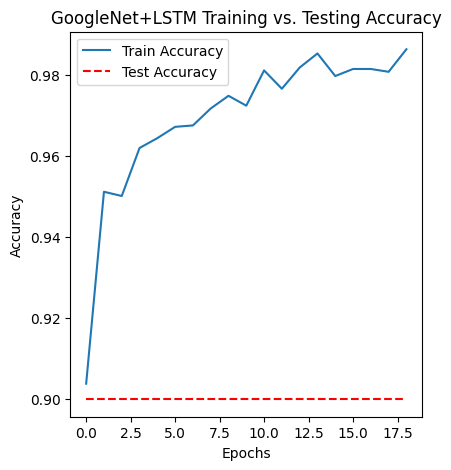

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot([0, len(history.history['accuracy']) - 1], [test_accuracy_inception, test_accuracy_inception], 'r--', label='Test Accuracy')
plt.title('GoogleNet+LSTM Training vs. Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

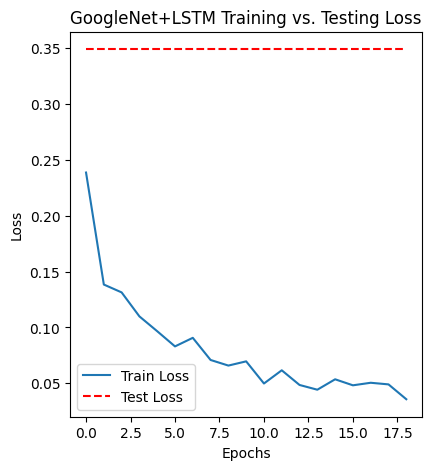

In [19]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot([0, len(history.history['loss']) - 1], [test_loss_inception, test_loss_inception], 'r--', label='Test Loss')
plt.title('GoogleNet+LSTM Training vs. Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, LSTM, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Set directories for training and testing data
train_dir = r'C:\Program Files\GoogleNet+LSTM\googlenet-lstm\dataset\Training'
test_dir = r'C:\Program Files\GoogleNet+LSTM\googlenet-lstm\dataset\Testing'

# Set image dimensions and batch size
img_height, img_width = 299, 299  # Default input size for InceptionV3
batch_size = 20
sequence_length = 5  # Define the sequence length for LSTM

# Prepare ImageDataGenerators for training and testing
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)  # No data augmentation for testing

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True  # Shuffle data for better training
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load InceptionV3 as base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for our specific classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

# Add LSTM layer
lstm_units = 256  # Number of units in the LSTM layer
lstm_input_features = 1024  # Number of features in the input to the LSTM layer
x = Reshape((1, lstm_input_features))(x)
x = LSTM(lstm_units, return_sequences=False)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Construct the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Setup early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('inception_lstm_model01.h5', monitor='val_loss', save_best_only=True)

# Fit the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model
model.evaluate(test_generator)



Found 2870 images belonging to 2 classes.
Found 220 images belonging to 2 classes.




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

144/144 [==============================] - ETA: 0s - loss: 0.2454 - accuracy: 0.9087

C:\Users\91868\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


144/144 [==============================] - 163s 1s/step - loss: 0.2454 - accuracy: 0.9087 - val_loss: 0.6400 - val_accuracy: 0.7318
Epoch 2/50
144/144 [==============================] - 152s 1s/step - loss: 0.1471 - accuracy: 0.9453 - val_loss: 0.7408 - val_accuracy: 0.7409
Epoch 3/50
144/144 [==============================] - 143s 990ms/step - loss: 0.1325 - accuracy: 0.9516 - val_loss: 0.6576 - val_accuracy: 0.7591
Epoch 4/50
144/144 [==============================] - 148s 1s/step - loss: 0.1253 - accuracy: 0.9537 - val_loss: 0.5525 - val_accuracy: 0.7682
Epoch 5/50
144/144 [==============================] - 148s 1s/step - loss: 0.1007 - accuracy: 0.9652 - val_loss: 0.5400 - val_accuracy: 0.7682
Epoch 6/50
144/144 [==============================] - 142s 983ms/step - loss: 0.0975 - accuracy: 0.9662 - val_loss: 0.4537 - val_accuracy: 0.8091
Epoch 7/50
144/144 [==============================] - 143s 990ms/step - loss: 0.0828 - accuracy: 0.9693 - val_loss: 0.5792 - val_accuracy: 0.7136
E

[0.302769273519516, 0.8909090757369995]

In [2]:
train_loss_inception, train_accuracy_inception = model.evaluate(train_generator)
test_loss_inception, test_accuracy_inception = model.evaluate(test_generator)

print(f'GoogleNet Model+LSTM - Training Data: Loss = {train_loss_inception}, Accuracy = {train_accuracy_inception}')
print(f'GoogleNet Model+LSTM - Testing Data: Loss = {test_loss_inception}, Accuracy = {test_accuracy_inception}')

11/11 [==============================] - 9s 808ms/step - loss: 0.3028 - accuracy: 0.8909
GoogleNet Model+LSTM - Training Data: Loss = 0.027331771329045296, Accuracy = 0.9919860363006592
GoogleNet Model+LSTM - Testing Data: Loss = 0.302769273519516, Accuracy = 0.8909090757369995


In [11]:
!pip install matplotlib

  Using cached matplotlib-3.8.4-cp310-cp310-win_amd64.whl.metadata (5.9 kB)
  Using cached contourpy-1.2.1-cp310-cp310-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.51.0-cp310-cp310-win_amd64.whl.metadata (162 kB)
  Using cached kiwisolver-1.4.5-cp310-cp310-win_amd64.whl.metadata (6.5 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
   ---------------------------------------- 0.0/7.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.7 MB ? eta -:--:--
   ---------------------------------------- 0.1/7.7 MB 525.1 kB/s eta 0:00:15
    --------------------------------------- 0.1/7.7 MB 590.8 kB/s eta 0:00:13
    --------------------------------------- 0.1/7.7 MB 654.9 kB/s eta 0:00:12
    --------------------------------------- 0.1/7.7 MB 654.9 kB/s eta 0:00:12
    --------------------------------------- 0.1/

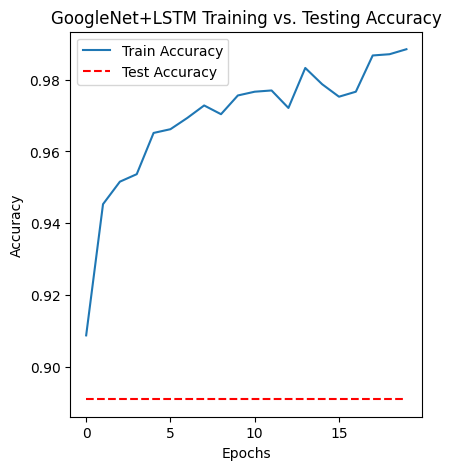

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
'''plt.plot(history.history['val_accuracy'], label='Validation Accuracy')'''
plt.plot([0, len(history.history['accuracy']) - 1], [test_accuracy_inception, test_accuracy_inception], 'r--', label='Test Accuracy')
plt.title('GoogleNet+LSTM Training vs. Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('GoogleNet+LSTM Training vs. Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()